In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Nevada
state_ab = "nv"

## Data
1. Download all the data in directory "nv_data"
2. Extract them all

In [5]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_2021/nv_cong_2021.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_2021/nv_sldu_2021.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_2021/nv_sldl_2021.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [6]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [7]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [8]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [9]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [10]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [11]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [12]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [13]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [15]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [16]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [17]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [18]:
maup.doctor(population_df)

100%|███████████████████████████████████| 57409/57409 [00:24<00:00, 2312.04it/s]


True

In [19]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [20]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [21]:
population_df.rename(columns=rename_dict, inplace = True)

In [22]:
county_df = county_df.to_crs(county_df.estimate_utm_crs())
maup.doctor(county_df)

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 437.25it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [25]:
vest20 = gpd.read_file(vest20_data)

In [26]:
vest20.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTY', 'VTDST', 'NAME', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREIBLA', 'G20PREONON', 'geometry'],
      dtype='object')

In [27]:
start_col = 5
vest_base_data = vest20
year = '20'

In [28]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 437.64it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 145.99it/s]


Identifying overlaps...


100%|█████████████████████████████████████| 8665/8665 [00:04<00:00, 2108.67it/s]


Resolving overlaps and filling gaps...


Gaps to fill in region 1: 100%|█████████████████| 26/26 [00:00<00:00, 27.90it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 3: 518it [02:41,  3.20it/s]                          
Gaps to fill in region 5: 100%|███████████████████| 4/4 [00:00<00:00, 91.75it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 7: 100%|███████████████| 1/1 [00:00<00:00, 48.34it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 10: 100%|██████████████| 129/129 [00:11<00:00, 11.34it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 12: 100%|██████████████| 2/2 [00:00<00:00, 35.57it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 13: 100%|██████████████████| 8/8 [00:00<00:00, 42.39it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 15: 100%|██████████████| 3/3 [00:00<00:00, 86.91it/s]
Gaps t

In [29]:
borders = check_small_boundary_lengths(vest_base)
print(borders[2500:2600])

[88.35746376404478, 88.3574637640448, 89.39839625192698, 89.39839625192701, 90.40572094160898, 90.40572094160898, 90.54655989488556, 90.54655989488556, 90.74873673634664, 90.74873673634664, 90.79061972471376, 90.79061972471376, 91.63945165629748, 91.63945165629748, 92.9912054246144, 92.9912054246144, 93.0096687994956, 93.0096687994956, 93.16808270924498, 93.16808270924498, 93.32145369466811, 93.32145369466811, 95.21378919974606, 95.21378919974606, 95.43639765453256, 95.43639765453256, 95.63841876508549, 95.63841876508549, 95.6955327142935, 95.6955327142935, 96.27599450525328, 96.2759945052533, 96.3034633691276, 96.3034633691276, 96.83226763866146, 96.83226763866148, 96.87894206863004, 96.87894206863004, 98.40627755804442, 98.40627755804442, 98.55879361645017, 98.55879361645017, 99.2155311149147, 99.2155311149147, 99.67443015029532, 99.67443015029532, 99.81850115592783, 99.81850115592783, 99.88124543953285, 99.88124543953286, 99.96422406752718, 99.96422406752718, 99.99774558637121, 99.9

In [30]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 2125/2125 [00:00<00:00, 4336.96it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]

Converting small rook adjacencies to queen...



100%|█████████████████████████████████████| 2094/2094 [00:01<00:00, 1629.41it/s]


In [31]:
maup.doctor(vest_base)

100%|█████████████████████████████████████| 2094/2094 [00:01<00:00, 1574.84it/s]


True

In [32]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 2094/2094 [00:04<00:00, 419.42it/s]


In [33]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [34]:
election_df = gpd.GeoDataFrame(vest_base)

In [35]:
election_df.columns

Index(['COUNTY', 'COUNTYFP', 'NAME', 'PRE20D', 'PRE20O', 'PRE20R', 'STATEFP',
       'VTDST', 'geometry', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK',
       'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE',
       'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP',
       'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [37]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [39]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [40]:
vest18.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTY', 'VTDST', 'NAME', 'G18USSDROS',
       'G18USSRHEL', 'G18USSLHAG', 'G18USSIBAK', 'G18USSNMIC', 'G18USSONON',
       'G18GOVDSIS', 'G18GOVRLAX', 'G18GOVLLOR', 'G18GOVIBES', 'G18GOVNBUN',
       'G18GOVONON', 'G18LTGDMAR', 'G18LTGRROB', 'G18LTGIHAN', 'G18LTGNUEH',
       'G18LTGONON', 'G18ATGDFOR', 'G18ATGRDUN', 'G18ATGIHAN', 'G18ATGONON',
       'G18SOSDARA', 'G18SOSRCEG', 'G18SOSONON', 'G18TREDCON', 'G18TRERBEE',
       'G18TREIHOG', 'G18TREONON', 'G18CONDBYR', 'G18CONRKNE', 'G18CONONON',
       'geometry'],
      dtype='object')

In [41]:
vest16.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTY', 'VTDST', 'NAME', 'G16PREDCLI',
       'G16PRERTRU', 'G16PRELJOH', 'G16PREICAS', 'G16PRENDEL', 'G16PREONON',
       'G16USSDCOR', 'G16USSRHEC', 'G16USSIJON', 'G16USSNSAW', 'G16USSNGUM',
       'G16USSNWIL', 'G16USSONON', 'geometry'],
      dtype='object')

In [42]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, 5)

100%|█████████████████████████████████████| 2071/2071 [00:01<00:00, 1548.14it/s]


There are 827 overlaps.
There are 2515 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 7560/7560 [00:02<00:00, 3326.08it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to simplify: 2858it [08:02,  5.92it/s]                                     
100%|██████████████████████████████████████| 2094/2094 [00:04<00:00, 419.32it/s]


population agrees


In [43]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R', 'BVAP',
       'CON18D', 'CON18O', 'CON18R', 'COUNTY', 'COUNTYFP', 'GOV18D', 'GOV18O',
       'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'LTG18D', 'LTG18O', 'LTG18R', 'NAME',
       'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI',
       'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE20D', 'PRE20O', 'PRE20R',
       'SOS18D', 'SOS18O', 'SOS18R', 'STATEFP', 'TOTPOP', 'TRE18D', 'TRE18O',
       'TRE18R', 'USS18D', 'USS18O', 'USS18R', 'VAP', 'VTDST', 'WVAP',
       'geometry'],
      dtype='object')

In [44]:
election_df = add_vest(vest16, election_df, '16', population_df, 5)

100%|█████████████████████████████████████| 2067/2067 [00:01<00:00, 1607.04it/s]


There are 872 overlaps.
There are 3377 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 8373/8373 [00:02<00:00, 3348.12it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to simplify: 3228it [19:03,  2.82it/s]                                     
100%|██████████████████████████████████████| 2094/2094 [00:05<00:00, 416.29it/s]


population agrees


##  Add the district data

In [46]:
cong_df = gpd.read_file(cd_data)
cong_df = cong_df.to_crs(cong_df.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [47]:
cong_df.head()

,DISTRICTNO,ADJPOP,TAWHITEALN,TABLACKCMB,TAAIANCMB,TAASIANCMB,TANHOPICMB,TAOTHERALN,TA2RACE,TAHISPANIC,...,AG18_OTH,SOS18_TOTA,SOS18_DEM,SOS18_REP,SOS18_OTH,PRES16_TOT,PRES16_DEM,PRES16_REP,PRES16_OTH,geometry
0,1.0,776153.0,354538.0,100814.0,23644.0,79806.0,12570.0,141719.0,119860.0,278903.0,...,12355.0,217447.0,112752.0,98140.0,6561.0,262162.0,136328.0,110157.0,15675.0,"POLYGON ((660969.105 3974025.168, 661211.168 3..."
1,2.0,776154.0,525157.0,25210.0,38061.0,48366.0,8339.0,83727.0,95806.0,179909.0,...,21133.0,296142.0,121192.0,166905.0,8050.0,332733.0,130319.0,174874.0,27546.0,"POLYGON ((240435.856 4339454.035, 240470.001 4..."
2,3.0,776153.0,373902.0,98120.0,18587.0,163953.0,18203.0,70274.0,102932.0,164069.0,...,12256.0,233159.0,118435.0,108595.0,6147.0,275077.0,138958.0,120464.0,15654.0,"POLYGON ((603868.870 3997901.943, 603868.757 3..."
3,4.0,776154.0,334866.0,151054.0,25498.0,61468.0,13420.0,140037.0,115411.0,267376.0,...,12071.0,209709.0,109055.0,94189.0,6436.0,252072.0,131689.0,105379.0,15001.0,"POLYGON ((296137.760 4297318.337, 296139.365 4..."


In [48]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICTNO")

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 27.01it/s]


In [49]:
send.head()

,DISTRICTNO,ADJPOP,TAWHITEALN,TABLACKCMB,TAAIANCMB,TAASIANCMB,TANHOPICMB,TAOTHERALN,TA2RACE,TAHISPANIC,...,AG18_OTH,SOS18_TOTA,SOS18_DEM,SOS18_REP,SOS18_OTH,PRES16_TOT,PRES16_DEM,PRES16_REP,PRES16_OTH,geometry
0,1.0,148528.0,55907.0,39774.0,4220.0,17452.0,3583.0,19810.0,23798.0,43370.0,...,1998.0,39528.0,23405.0,15030.0,1099.0,47483.0,27388.0,17139.0,2952.0,"POLYGON ((658899.403 4022527.501, 658939.707 4..."
1,2.0,149050.0,34767.0,24267.0,5268.0,5682.0,1266.0,58798.0,26035.0,96390.0,...,1381.0,19753.0,14368.0,4634.0,753.0,27697.0,20379.0,5854.0,1469.0,"POLYGON ((665018.185 4003129.747, 665018.254 4..."
2,3.0,148851.0,58337.0,25773.0,4680.0,12864.0,2395.0,33248.0,22103.0,59602.0,...,2269.0,38024.0,21155.0,15710.0,1135.0,47775.0,26699.0,18225.0,2846.0,"POLYGON ((654630.085 4012057.890, 654673.566 4..."
3,4.0,148627.0,33841.0,42979.0,4854.0,8343.0,2314.0,42702.0,23218.0,72041.0,...,1740.0,31565.0,22927.0,7461.0,1182.0,40792.0,29919.0,8940.0,1930.0,"POLYGON ((659395.308 4011273.032, 659407.730 4..."
4,5.0,149268.0,89420.0,15951.0,4395.0,18124.0,2968.0,11040.0,20765.0,30539.0,...,2888.0,51512.0,24062.0,25944.0,1502.0,59074.0,26921.0,28285.0,3873.0,"POLYGON ((669530.994 3986975.926, 669530.970 3..."


In [50]:
election_df = add_district(send, "SEND", election_df, "DISTRICTNO")

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 45.54it/s]


In [51]:
hdist.head()

,DISTRICTNO,ADJPOP,TAWHITEALN,TABLACKCMB,TAAIANCMB,TAASIANCMB,TANHOPICMB,TAOTHERALN,TA2RACE,TAHISPANIC,...,AG18_OTH,SOS18_TOTA,SOS18_DEM,SOS18_REP,SOS18_OTH,PRES16_TOT,PRES16_DEM,PRES16_REP,PRES16_OTH,geometry
0,1.0,74334.0,32160.0,15828.0,1929.0,9274.0,1839.0,9131.0,11693.0,20399.0,...,1208.0,24031.0,13067.0,10317.0,652.0,28146.0,14970.0,11458.0,1714.0,"POLYGON ((658899.403 4022527.501, 658939.707 4..."
1,2.0,74292.0,45074.0,6466.0,1282.0,14164.0,1011.0,3327.0,8614.0,10249.0,...,1276.0,28713.0,12862.0,15195.0,657.0,33041.0,15293.0,16025.0,1723.0,"POLYGON ((646995.466 4003125.221, 647093.555 4..."
2,3.0,74369.0,30313.0,14101.0,2350.0,5170.0,1227.0,15389.0,11461.0,28556.0,...,1164.0,20067.0,10951.0,8508.0,608.0,25020.0,13564.0,9946.0,1511.0,"POLYGON ((654630.085 4012057.890, 654673.566 4..."
3,4.0,73454.0,40970.0,11375.0,2165.0,7260.0,1494.0,6364.0,10796.0,16338.0,...,1446.0,26402.0,12045.0,13659.0,688.0,30402.0,13544.0,15014.0,1854.0,"POLYGON ((649700.581 4014687.856, 649717.797 4..."
4,5.0,74210.0,37497.0,10292.0,1792.0,13856.0,1335.0,5972.0,9515.0,14666.0,...,1194.0,23339.0,12272.0,10477.0,591.0,28569.0,14852.0,12025.0,1688.0,"POLYGON ((651491.876 4002894.924, 651523.283 4..."


In [52]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICTNO")

100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 75.08it/s]


In [53]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R', 'BVAP',
       'CON18D', 'CON18O', 'CON18R', 'COUNTY', 'COUNTYFP', 'GOV18D', 'GOV18O',
       'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'LTG18D', 'LTG18O', 'LTG18R', 'NAME',
       'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI',
       'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE16D', 'PRE16O', 'PRE16R',
       'PRE20D', 'PRE20O', 'PRE20R', 'SOS18D', 'SOS18O', 'SOS18R', 'STATEFP',
       'TOTPOP', 'TRE18D', 'TRE18O', 'TRE18R', 'USS16D', 'USS16O', 'USS16R',
       'USS18D', 'USS18O', 'USS18R', 'VAP', 'VTDST', 'WVAP', 'geometry', 'CD',
       'SEND', 'HDIST'],
      dtype='object')

### Put the base precinct year after the precinct information column

In [55]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'COUNTY':'COUNTY'+year,
        'VTDST':'VTDST'+year,
        'NAME':'NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [56]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R', 'BVAP',
       'CON18D', 'CON18O', 'CON18R', 'COUNTY20', 'COUNTYFP20', 'GOV18D',
       'GOV18O', 'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN',
       'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'LTG18D', 'LTG18O', 'LTG18R',
       'NAME20', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK',
       'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE16D', 'PRE16O',
       'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS18D', 'SOS18O', 'SOS18R',
       'STATEFP20', 'TOTPOP', 'TRE18D', 'TRE18O', 'TRE18R', 'USS16D', 'USS16O',
       'USS16R', 'USS18D', 'USS18O', 'USS18R', 'VAP', 'VTDST20', 'WVAP',
       'geometry', 'CD', 'SEND', 'HDIST'],
      dtype='object')

In [57]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'COUNTY'+year,
    'VTDST'+year,
    'NAME'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [58]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

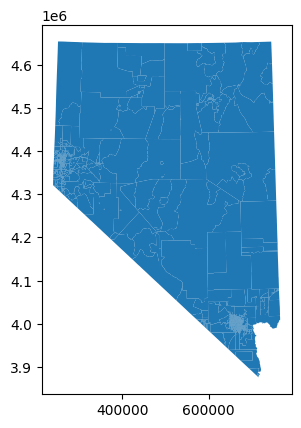

In [59]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()

In [60]:
len(election_df.columns)

64